In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import load_model

from sklearn.metrics import accuracy_score, roc_curve, auc
import seaborn as sns

import copy

In [2]:
models = ['DetectNet','DNN', 'CNN', 'LSTM']
_mods = ['BPSK', 'QPSK', '8PSK', 'PAM4', 'QAM16', 'QAM64', 'GFSK', 'CPFSK', ]
sample_length = [64,128,256,512,1024]

In [3]:
def radioml_IQ_data(filename, mod_name, _snr= -10, swap_dim = False):
    '''
        load dataset for single node model training
    '''
    snrs=""
    mods=""
    lbl =""
    Xd = pickle.load(open(filename,'rb'),encoding='latin')
    snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
    X = []  
    lbl = []
    for mod in mods:
        for snr in snrs:
            if(snr == _snr):
                X.append(Xd[(mod,snr)])
                for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
    X = np.vstack(X)
    
#     use QAM16 signal only
    lbl = np.array(lbl) 
    index = np.where(lbl==mod_name)[0] 
    X = X[index]
    lbl = lbl[index]
    
    maxlen = X.shape[-1]
    SNR = []
    for item in lbl:
        SNR.append(item[-1])
    SNR = np.array(SNR,dtype='int16')
    
    noise_vectors = []
    for i in range(X.shape[0]):
        real = np.random.randn(maxlen) 
        imag = np.random.randn(maxlen)
        complex_noise_vector = real + 1j*imag
        energy = np.sum(np.abs(complex_noise_vector)**2)
        noise_vector = complex_noise_vector / (energy**0.5)
        real = np.real(noise_vector)
        imag = np.imag(noise_vector)
        noise_vectors.append([real,imag])
    noise_vectors = np.array(noise_vectors)   
    
    # one-hot label, [1,0] with signal, [0,1] noise only
    dataset = np.concatenate((X,noise_vectors),axis=0)
    labelset = np.concatenate(([[1,0]]*len(X),[[0,1]]*len(noise_vectors)),axis=0)
    labelset = np.array(labelset,dtype='int16')
    # use snr -100 to represent noise samples
    SNR = np.concatenate((SNR,[-100]*len(noise_vectors)),axis=0) 

    total_num = len(dataset)
    shuffle_idx = np.random.choice(range(0,total_num), size=total_num,replace=False)
    
    dataset = dataset[shuffle_idx]
    labelset = labelset[shuffle_idx]
    SNR = SNR[shuffle_idx]
    
    # split the whole dataset with ratio 3:1:1 into training, validation and testing set
    train_num = int(total_num*0.6)
    val_num = int(total_num*0.2)
    
    if(swap_dim):
        dataset = np.einsum('ijk->ikj', dataset)

    return dataset, labelset, SNR

## Varia modulação

Loading  result/models/DetectNet/128/BPSKfinal.h5
Loading  result/models/DetectNet/128/QPSKfinal.h5
Loading  result/models/DetectNet/128/8PSKfinal.h5
Loading  result/models/DetectNet/128/PAM4final.h5
Loading  result/models/DetectNet/128/QAM16final.h5
Loading  result/models/DetectNet/128/QAM64final.h5
Loading  result/models/DetectNet/128/GFSKfinal.h5
Loading  result/models/DetectNet/128/CPFSKfinal.h5


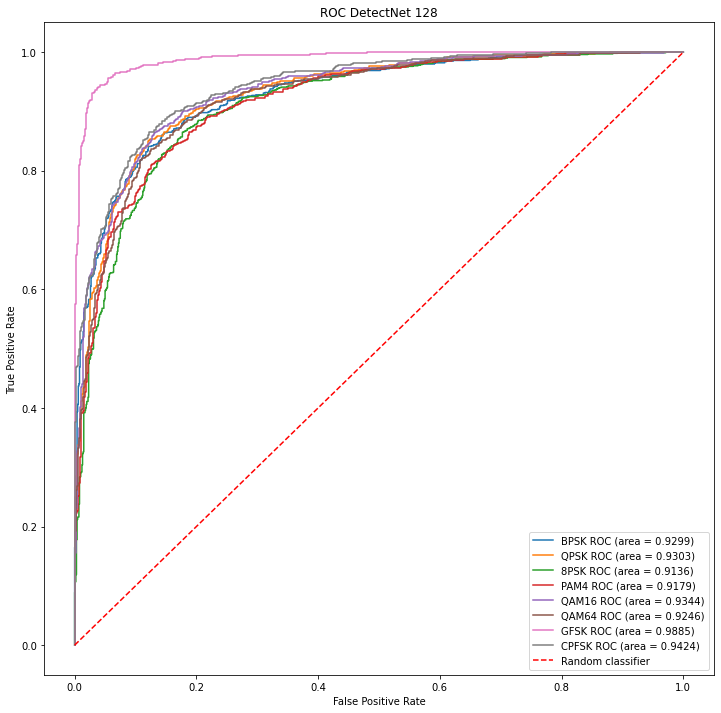

In [4]:
_model = 'DetectNet'
_sample_length = 128

filename = 'pkl_data/'+str(_sample_length)+'.pkl'

plt.figure(figsize=[12,12])
for mod in _mods:
    
    if(_sample_length != 1024 and _model == 'DetectNet'):
        x, y, snr = radioml_IQ_data(filename,mod_name=mod, _snr= -10, swap_dim=True)
    else:
        x, y, snr = radioml_IQ_data(filename,mod_name=mod, _snr= -10, swap_dim=False)
        
    #carrega modelo
    best_model_path = 'result/models/'+str(_model)+'/'+str(_sample_length)+'/'+str(mod)+'final.h5'
    print("Loading ", best_model_path)
    model = load_model(best_model_path)
    #faz predicao e desencode
    y_pred = model.predict(x)
    y_column = np.asarray([np.where(r<0.5)[0] for r in y]).reshape(-1)
    #gera ROC
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_column, y_pred[:, 0])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    #print("auc: ", roc_auc)
    
    #plota ROC
    plt.plot(false_positive_rate, true_positive_rate, label='{:s} ROC (area = {:.4f})'.format(mod,roc_auc))

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC {:s} {:d}'.format(_model, _sample_length))
plt.legend(loc="lower right")
plt.savefig('imagens/ROC_{:s}_{:d}.png'.format(_model, _sample_length))
plt.show()


## Varia número de features

Loading  result/models/DetectNet/64/QAM16final.h5
Loading  result/models/DetectNet/128/QAM16final.h5
Loading  result/models/DetectNet/256/QAM16final.h5
Loading  result/models/DetectNet/512/QAM16final.h5
Loading  result/models/DetectNet/1024/QAM16final.h5


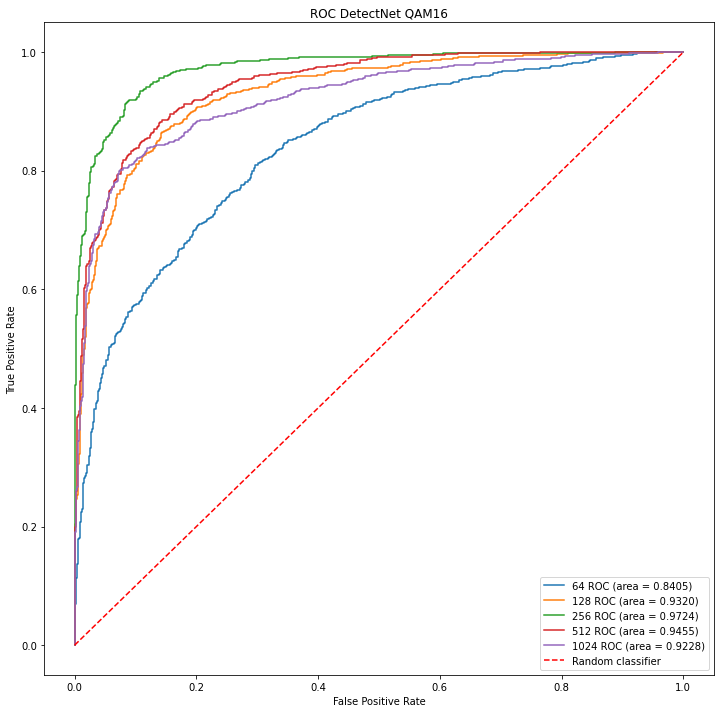

In [5]:
_model = 'DetectNet'
mod = 'QAM16'

plt.figure(figsize=[12,12])
for _sample_length in sample_length:
    filename = 'pkl_data/'+str(_sample_length)+'.pkl'
    if(_sample_length != 1024 and _model == 'DetectNet'):
        x, y, snr = radioml_IQ_data(filename,mod_name=mod, _snr= -10, swap_dim=True)
    else:
        x, y, snr = radioml_IQ_data(filename,mod_name=mod, _snr= -10, swap_dim=False)
        
    #carrega modelo
    best_model_path = 'result/models/'+str(_model)+'/'+str(_sample_length)+'/'+str(mod)+'final.h5'
    print("Loading ", best_model_path)
    model = load_model(best_model_path)
    #faz predicao e desencode
    y_pred = model.predict(x)
    y_column = np.asarray([np.where(r<0.5)[0] for r in y]).reshape(-1)
    #gera ROC
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_column, y_pred[:, 0])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    #print("auc: ", roc_auc)
    
    #plota ROC
    plt.plot(false_positive_rate, true_positive_rate, label='{:d} ROC (area = {:.4f})'.format(_sample_length,roc_auc))

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC {:s} {:s}'.format(_model, mod))
plt.legend(loc="lower right")
plt.savefig('imagens/ROC_{:s}_{:s}.png'.format(_model, mod))
plt.show()


## Varia modelo

Loading  result/models/DetectNet/128/QAM16final.h5
Loading  result/models/DNN/128/QAM16final.h5
Loading  result/models/CNN/128/QAM16final.h5
Loading  result/models/LSTM/128/QAM16final.h5


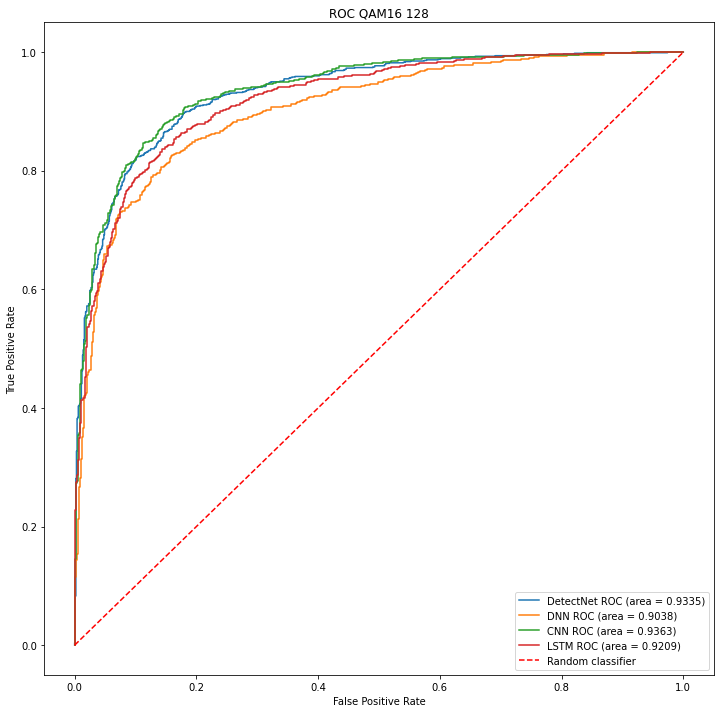

In [6]:
mod = 'QAM16'
_sample_length = 128

filename = 'pkl_data/'+str(_sample_length)+'.pkl'

plt.figure(figsize=[12,12])
for _model in models:
    
    if(_sample_length != 1024 and _model == 'DetectNet'):
        x, y, snr = radioml_IQ_data(filename,mod_name=mod, _snr= -10, swap_dim=True)
    else:
        x, y, snr = radioml_IQ_data(filename,mod_name=mod, _snr= -10, swap_dim=False)
        
    #carrega modelo
    best_model_path = 'result/models/'+str(_model)+'/'+str(_sample_length)+'/'+str(mod)+'final.h5'
    print("Loading ", best_model_path)
    model = load_model(best_model_path)
    #faz predicao e desencode
    y_pred = model.predict(x)
    y_column = np.asarray([np.where(r<0.5)[0] for r in y]).reshape(-1)
    #gera ROC
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_column, y_pred[:, 0])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    #print("auc: ", roc_auc)
    
    #plota ROC
    plt.plot(false_positive_rate, true_positive_rate, label='{:s} ROC (area = {:.4f})'.format(_model,roc_auc))

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC {:s} {:d}'.format(mod, _sample_length))
plt.legend(loc="lower right")
plt.savefig('imagens/ROC_{:s}_{:d}.png'.format(mod, _sample_length))
plt.show()
